# Conformal Riemann-Lorentz Case

In [1]:
#JAX
import jax.numpy as jnp
import jax.random as jran
from jax import vmap

#Scipy
from scipy.ndimage.filters import gaussian_filter

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


#JaxMan
from JaxMan.manifold.riemannian.RiemannianManifold import RiemannianManifold
from JaxMan.manifold.lorentzian.LorentzianManifold import LorentzianManifold

/tmp/ipykernel_171454/3023412132.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Define File Paths

In [2]:
figure_path = 'Figures/conformal_rl/'

## Defining Mappings

In [3]:
mua_fun = lambda t,x: (1+t+x[0]**2+x[1]**2)*0.5/((1+t)**2)
mub_fun = lambda t,x: (1+t+x[0]**2+x[1]**2)*0.5/((1+t)**2)
mutheta_fun = lambda t,x: 0.0

sigmaa_fun = lambda t,x: 1-jnp.exp(-(x[0]+x[1]+t)**4)
sigmab_fun = lambda t,x: 1-jnp.exp(-(x[1]+x[1]+t)**4)
sigmatheta_fun = lambda t,x: 0.0

In [4]:
def G(t, x, eps = jnp.zeros(3)):
    
    theta = mutheta_fun(t,x)+eps[0]*sigmatheta_fun(t,x)
    a2 = (mua_fun(t,x)+eps[1]*sigmaa_fun(t,x))**2
    b2 = (mub_fun(t,x)+eps[2]*sigmab_fun(t,x))**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Defining grid

In [5]:
N_grid = 100
start = -2.0
end = 2.0

t_grid = jnp.linspace(0,1,N_grid)
x1_grid = jnp.linspace(start,end,N_grid)
x2_grid = jnp.linspace(start,end,N_grid)
X1_grid, X2_grid = jnp.meshgrid(x1_grid,x2_grid)
X_grid = jnp.concatenate((X1_grid.reshape(N_grid, N_grid, 1), 
                          X2_grid.reshape(N_grid, N_grid, 1)), axis=-1)


N_plot = 10
t_plot = jnp.linspace(0,1,N_plot)
x1_plot = jnp.linspace(start,end,N_plot)
x2_plot = jnp.linspace(start,end,N_plot)
X1_plot, X2_plot = jnp.meshgrid(x1_plot,x2_plot)
X_plot = jnp.concatenate((X1_plot.reshape(N_plot, N_plot, 1), 
                          X2_plot.reshape(N_plot, N_plot, 1)), axis=-1)

## Define Stochastic Pertubations

In [6]:
N_sim = 100
seed = 2721
key = jran.PRNGKey(seed)
eps = jran.normal(key, shape=(N_sim,3))

## Riemannian Setting

In [7]:
RM = RiemannianManifold(G=lambda x: G(0.0, x, jnp.zeros(3)), dim=2, 
                        GeodesicMethod="ODE", ODEMethod = "rk4", maxiter=10000, tol=1e-6)

### Indicatrices 

In [8]:
def indicatrix(x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = mua_fun(0.0,x)
    b = mub_fun(0.0,x)
    theta = mutheta_fun(0.0,x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [9]:
q1, q2 = vmap(lambda y: vmap(lambda x: indicatrix(x))(y))(X_plot)

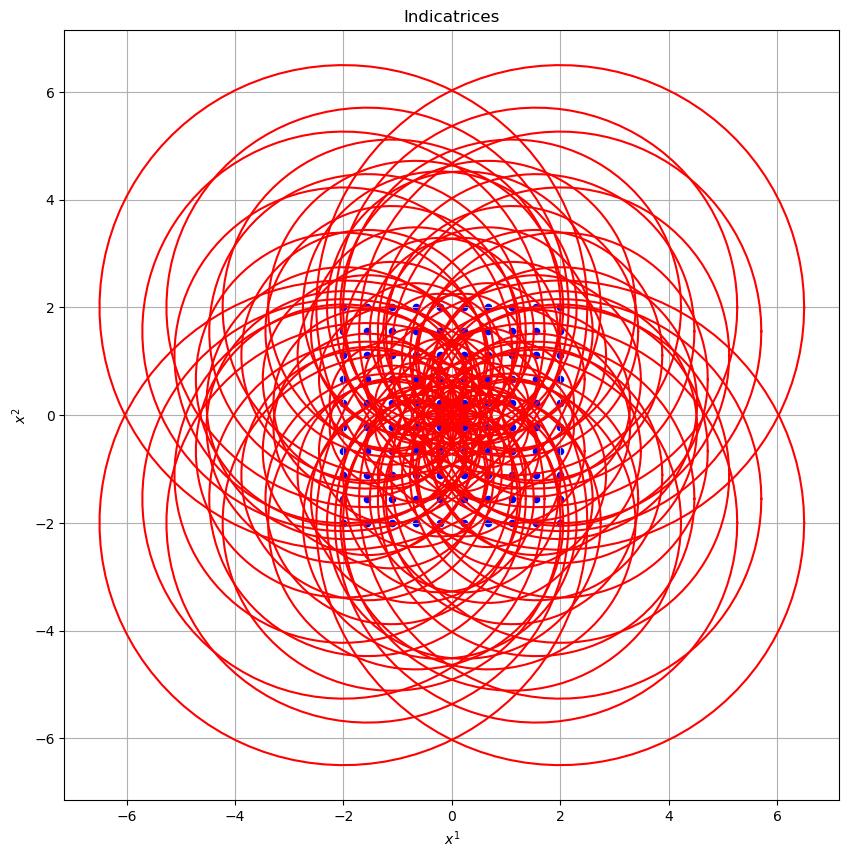

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_plot):
    for j in range(N_plot):
        ax.plot(q1[i,j,:], q2[i,j,:], color='red')
        ax.scatter(X_plot[i,j,0], X_plot[i,j,1], color='blue', s=20)

ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()

plt.show()
fig.savefig(figure_path+'rm_indicatrix.pdf', format="pdf", bbox_inches="tight")

### Computing the Metric

In [11]:
g = vmap(lambda y: vmap(lambda x: jnp.sqrt(jnp.linalg.det(RM.G(x))))(y))(X_grid)

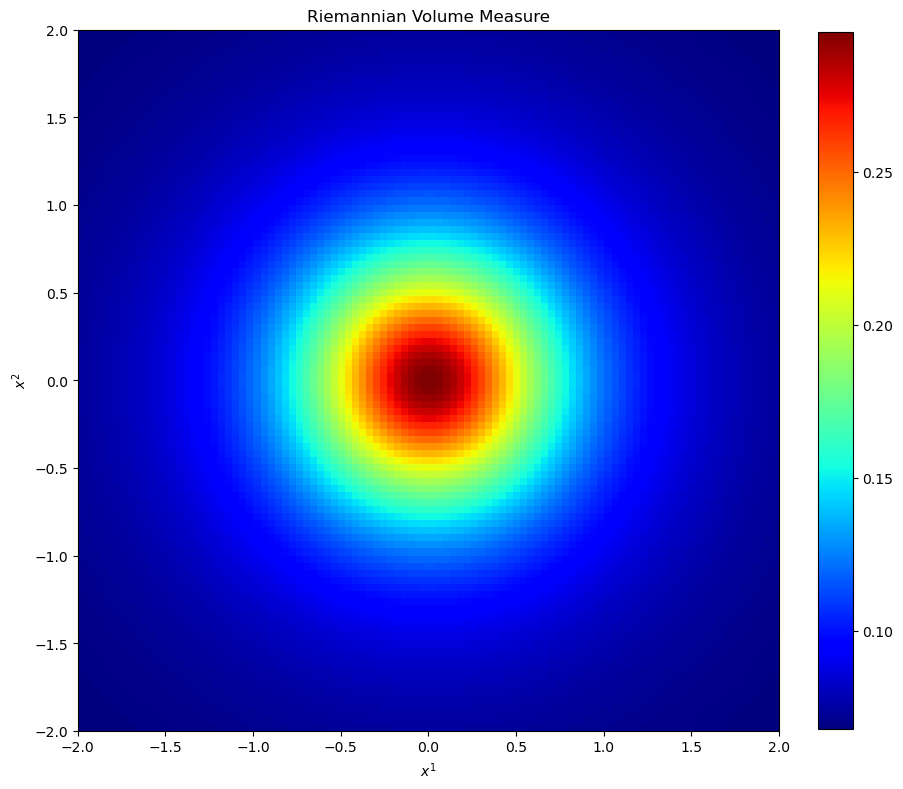

In [12]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
extent = [start, end, start, end]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(g.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([start, end])
ax.set_ylim([start, end])
ax.set_title("Riemannian Volume Measure")
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(g[i])
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
fig.savefig(figure_path+'rm_volume.pdf', format="pdf", bbox_inches="tight")

### IVP Geodesics

In [13]:
N_spray = 100
p0 = jnp.zeros(2)+0.2
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T
v = v.T/vmap(lambda w: jnp.sqrt(w.dot(RM.G(p0)).dot(w)))(v)

rm_grid, rm_gamma, rm_dgamma = vmap(lambda v: RM.IVPGeodesic(p0, v, T=2.0))(v.T)

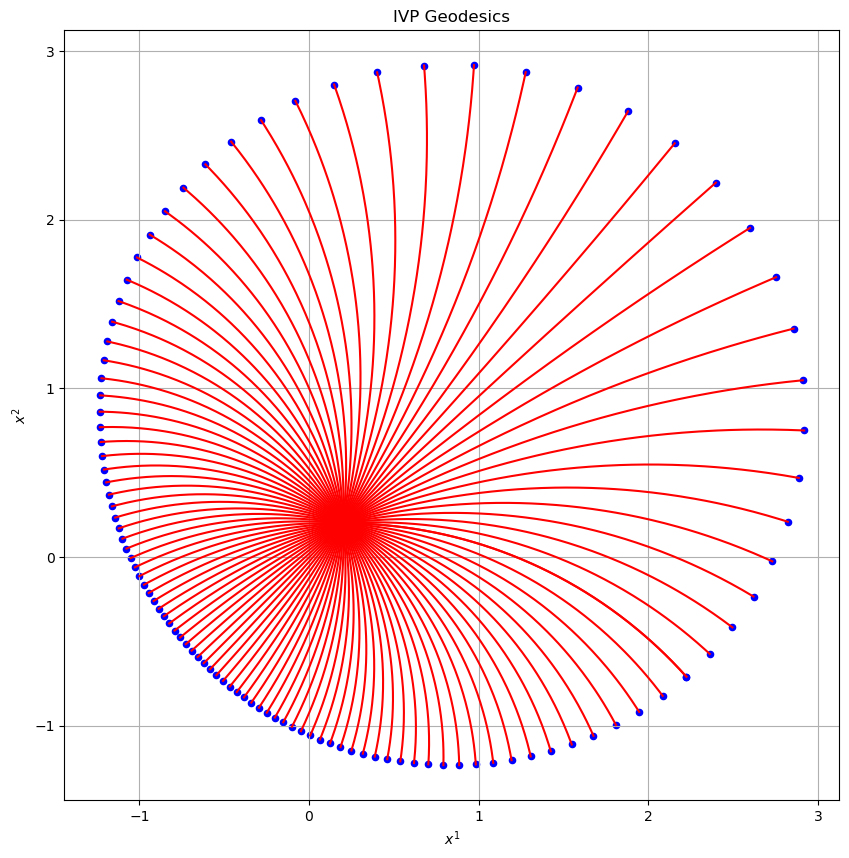

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rm_gamma[:,:,0].T, rm_gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(rm_gamma[:,-1,0], rm_gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig(figure_path+'rm_ivp2d.pdf', format="pdf", bbox_inches="tight")

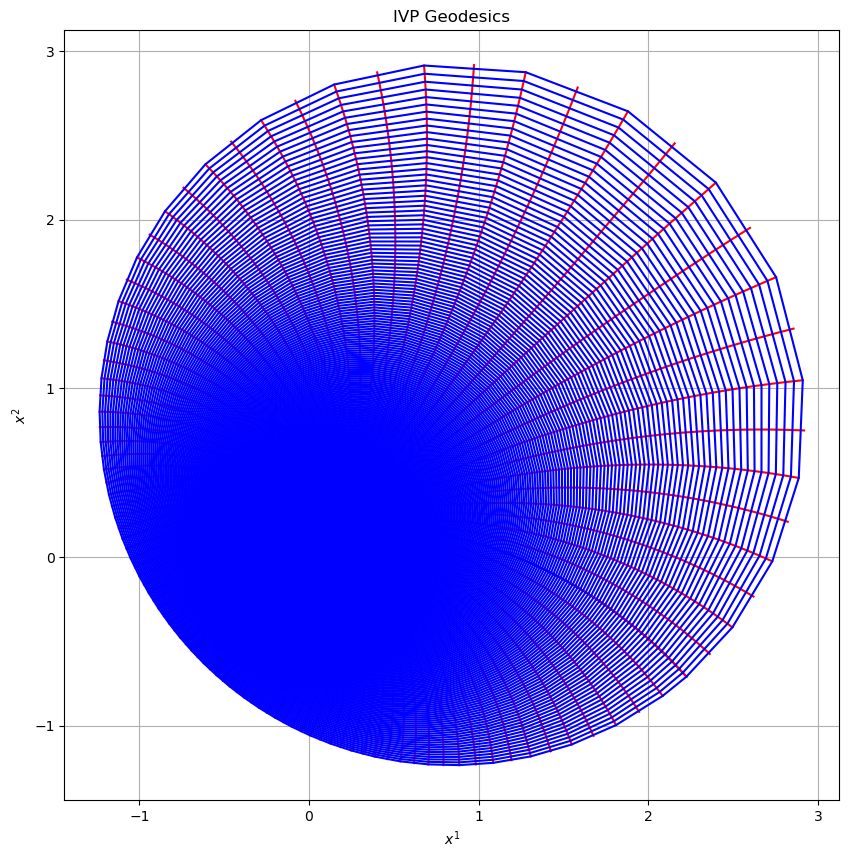

In [15]:
rm_gamma_circle = jnp.concatenate((rm_gamma, rm_gamma[0].reshape(1,rm_gamma.shape[1], rm_gamma.shape[2])))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rm_gamma[:,:,0].T, rm_gamma[:,:,1].T, color='red')
ax.plot(rm_gamma_circle[:,:,0][::2], rm_gamma_circle[:,:,1][::2], color='blue')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.grid()
fig.savefig(figure_path+'rm_ivp2d_circle.pdf', format="pdf", bbox_inches="tight")

### Converting Geodesics to Sphere using Steographic Projection

In [16]:
def F_steographic(x):
            
    s2 = jnp.sum(x**2)
    
    return jnp.concatenate(((1-s2).reshape(1), 2*x))/(1+s2)
                    
def invF_steographic(x):

    x0 = x[0]

    return vmap(lambda xi: xi/(1+x0))(x[1:])

In [17]:
rm_gamma_steopgrahic = vmap(lambda x: vmap(lambda y: F_steographic(y))(x))(rm_gamma)

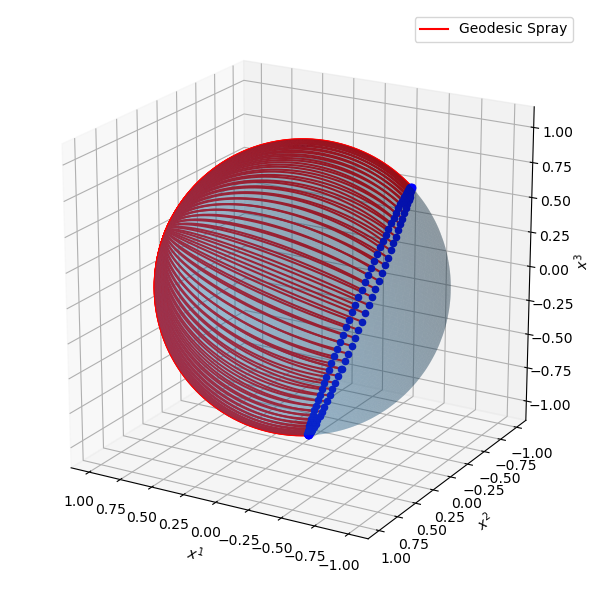

In [18]:
phi = jnp.linspace(-jnp.pi, jnp.pi, 100)
theta = jnp.linspace(-jnp.pi*0.5, jnp.pi*0.5, 100)
X1_heat = jnp.outer(jnp.cos(phi), jnp.cos(theta))
X2_heat = jnp.outer(jnp.sin(phi), jnp.cos(theta))
X3_heat = jnp.outer(jnp.ones_like(phi), jnp.sin(theta))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, alpha=0.25)

for i in range(len(rm_gamma_steopgrahic)-1):
    ax.plot(rm_gamma_steopgrahic[i][:,0], rm_gamma_steopgrahic[i][:,1], 
            rm_gamma_steopgrahic[i][:,2],color='red')
    ax.scatter(rm_gamma_steopgrahic[i][-1,0], rm_gamma_steopgrahic[i][-1,1], 
               rm_gamma_steopgrahic[i][-1,2],color='blue',
              s=20)
ax.plot(rm_gamma_steopgrahic[-1][:,0], rm_gamma_steopgrahic[-1][:,1], rm_gamma_steopgrahic[-1][:,2],
        color='red',
       label='Geodesic Spray')
ax.scatter(rm_gamma_steopgrahic[-1][-1,0], rm_gamma_steopgrahic[i][-1,1], rm_gamma_steopgrahic[-1][-1,2],
           color='blue',
              s=20)
ax.view_init(20,120)
ax.legend()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$x^{3}$')
ax.set_xlim((-1.1, 1.1))
ax.set_ylim((-1.1, 1.1))
ax.set_zlim((-1.1, 1.1))
#ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
plt.tight_layout()
ax.set_box_aspect([1,1,1]) 
fig.savefig(figure_path+'rm_ivp3d.pdf', format="pdf", bbox_inches="tight")

### Sectional Curvature

In [19]:
N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: RM.SectionalCurvature(y, e1, e2))(x))(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


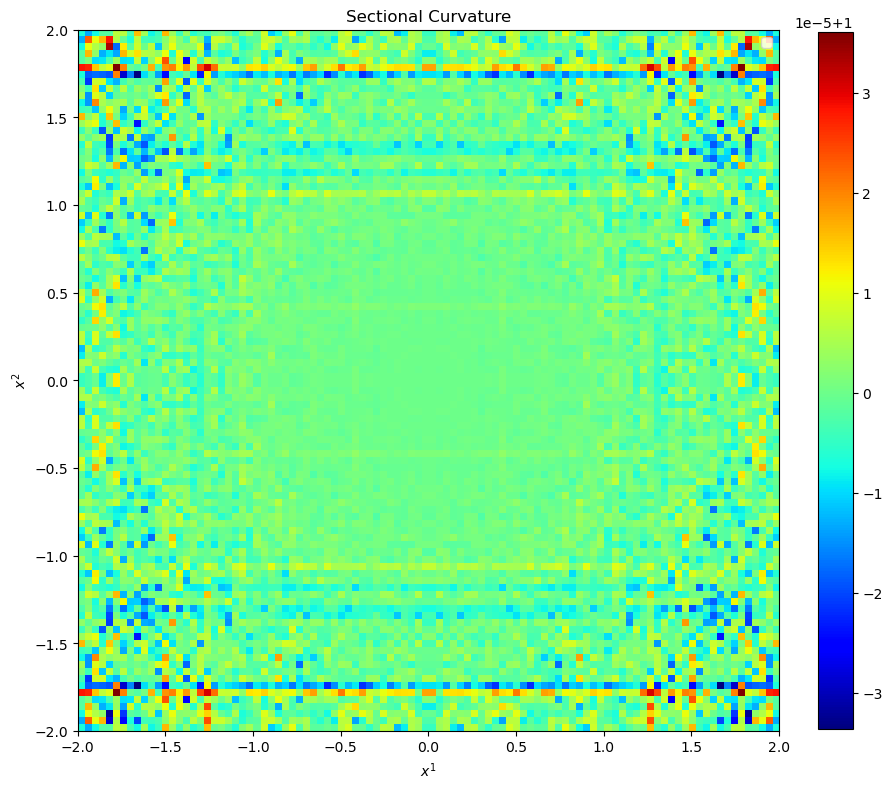

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig(figure_path+'rm_curvature.pdf', format="pdf", bbox_inches="tight")

## Deterministic Setting

### Defining The Manifold

In [21]:
LM = LorentzianManifold(h=lambda t,x: G(t,x,jnp.zeros(3)), dim=2, GeodesicMethod="ODE")

### Indicatrices 

In [22]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = mua_fun(t,x)
    b = mub_fun(t,x)
    theta = mutheta_fun(t,x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [23]:
t_val = jnp.array([0.0, 0.5, 1.0])
q1, q2 = vmap(lambda t: vmap(lambda y: vmap(lambda x: indicatrix(t, x))(y))(X_plot))(t_val)

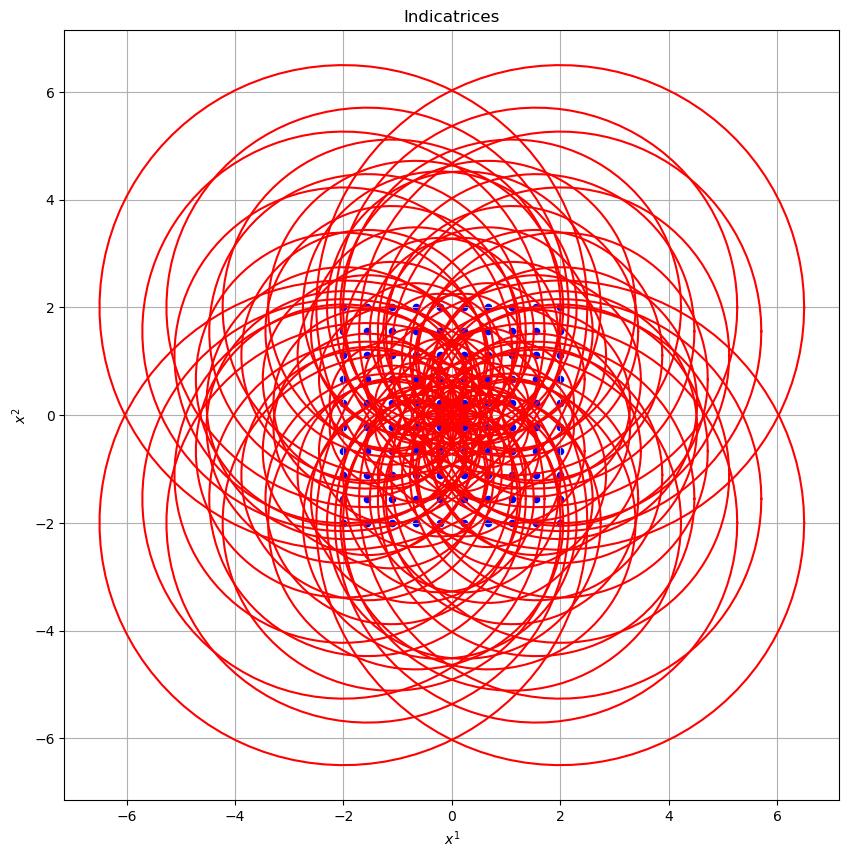

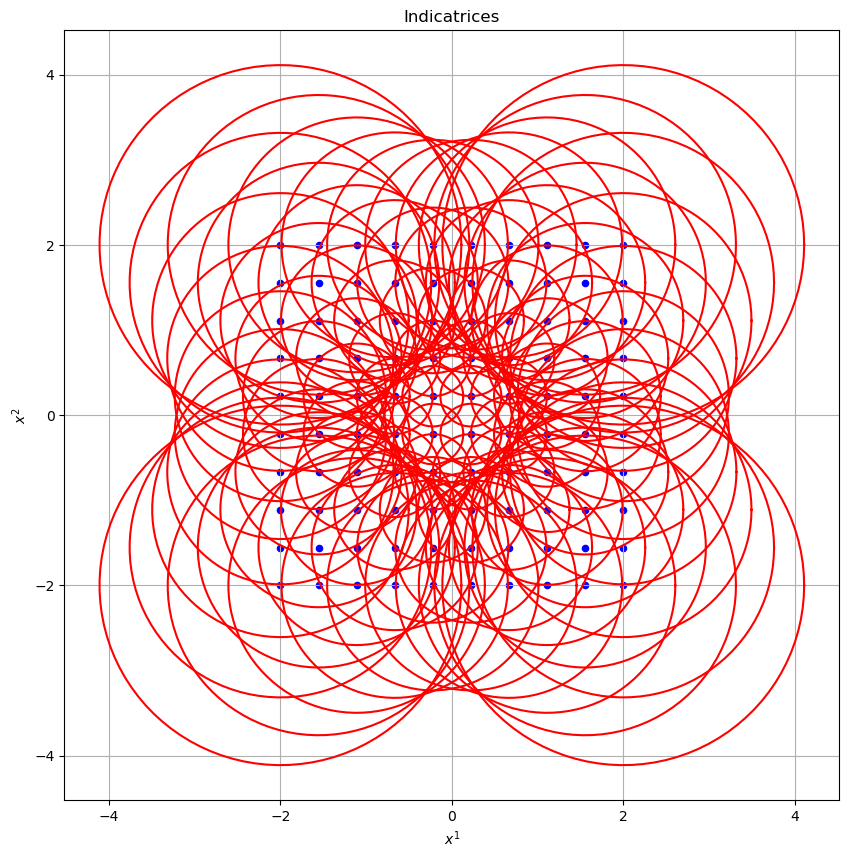

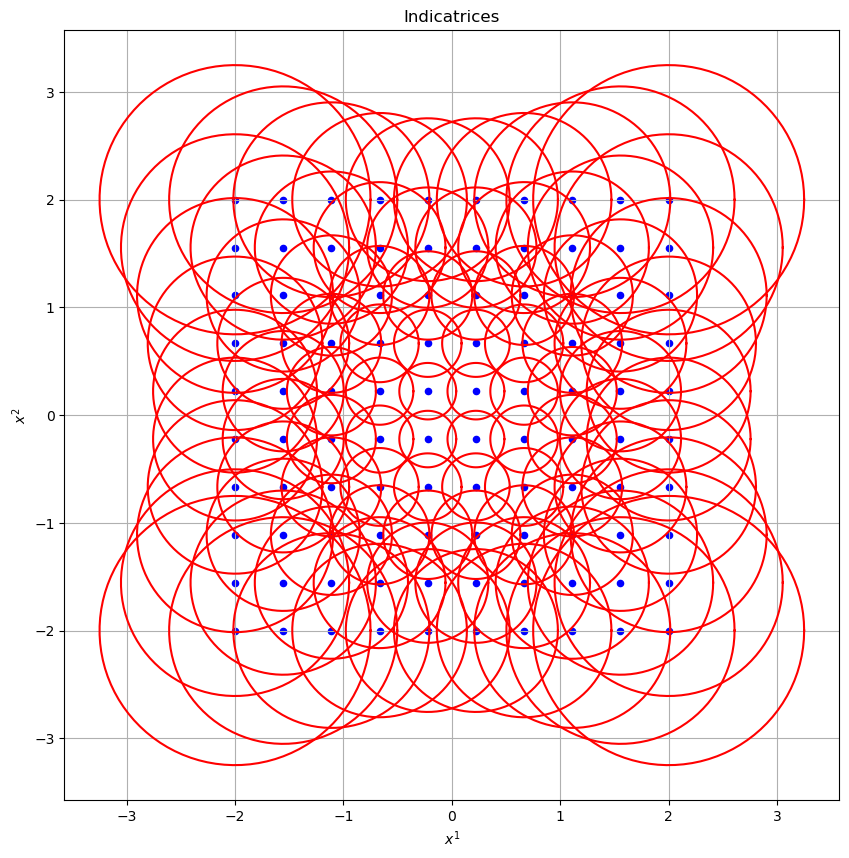

In [24]:
for k in range(3):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for i in range(N_plot):
        for j in range(N_plot):
            ax.plot(q1[k,i,j,:], q2[k,i,j,:], color='red')
            ax.scatter(X_plot[i,j,0], X_plot[i,j,1], color='blue', s=20)
            
    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    ax.set_title("Indicatrices")
    ax.grid()
    
    plt.show()
    fig.savefig(figure_path+'indicatrix'+str(t_val[k]).replace('.','_')+'.pdf', format="pdf", bbox_inches="tight")

### Computing the Metric

In [25]:
t_val = jnp.array([0.0, 0.5, 1.0])

g = vmap(lambda t: vmap(lambda y: vmap(lambda x: jnp.sqrt(jnp.linalg.det(LM.G(t,x))))(y))(X_grid))(t_val)

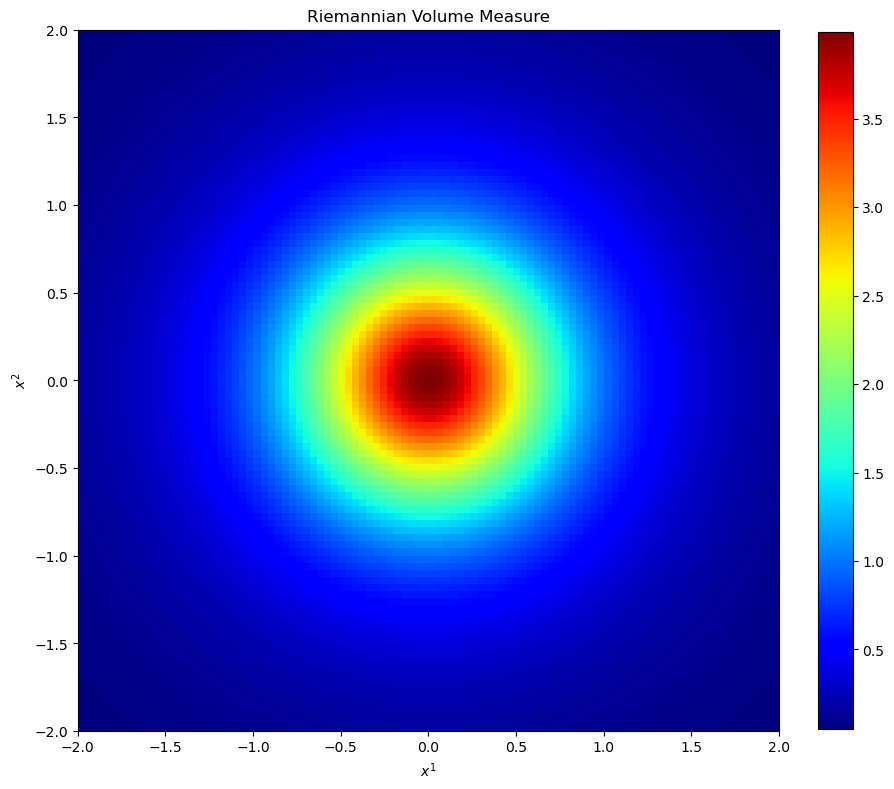

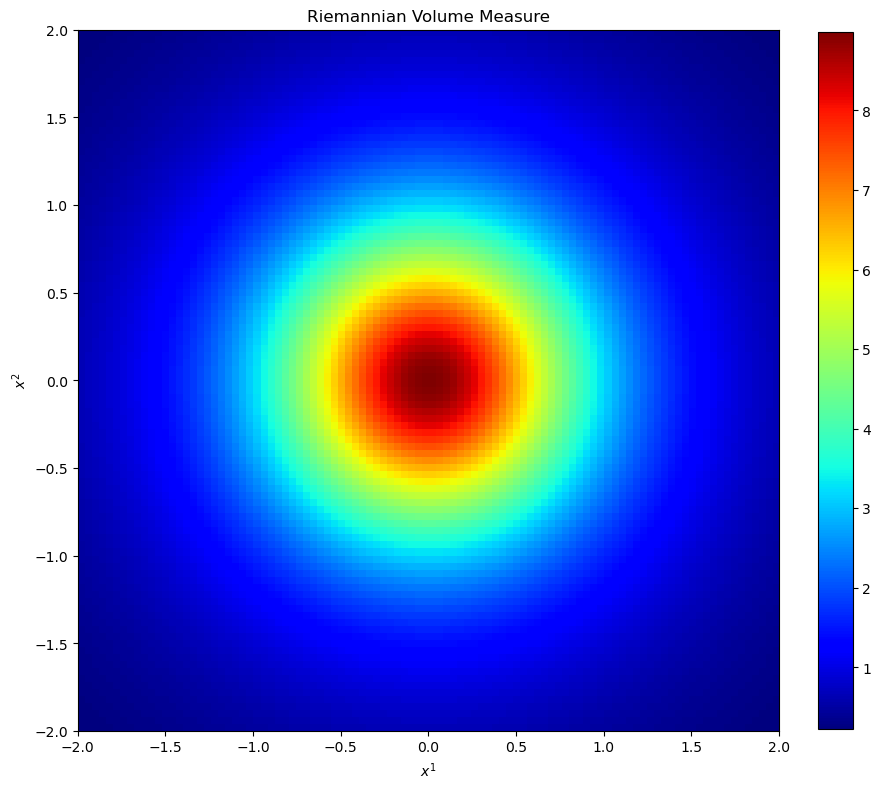

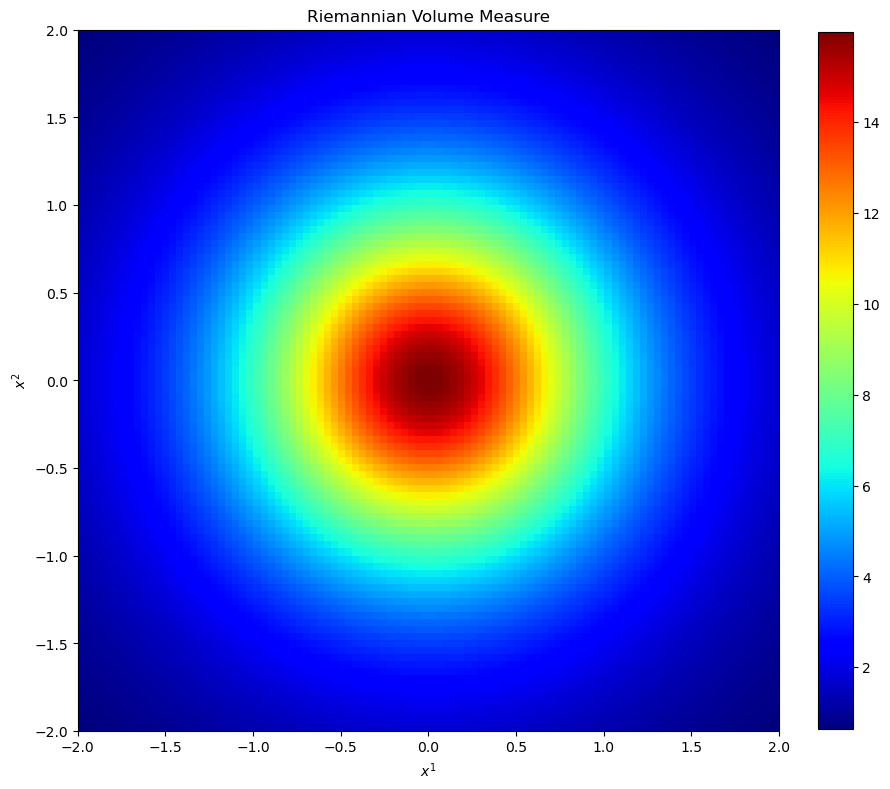

In [26]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
extent = [start, end, start, end]
for i in range(len(g)):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(g[i].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    ax.set_title("Riemannian Volume Measure")
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[i])
    fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

    plt.show()
    fig.savefig(figure_path+'volume'+str(t_val[i]).replace('.','_')+'.pdf', format="pdf", bbox_inches="tight")

### Wave Map Geodesics

In [29]:
N_spray = 100
p0 = jnp.zeros(2)+0.2
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T
v = v.T/vmap(lambda w: jnp.sqrt(w.dot(G(0,p0,jnp.ones(3))).dot(w)))(v)

v = jnp.concatenate((jnp.ones(N_spray).reshape(1,-1), v)).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(p0, v, T=1.0))(v)

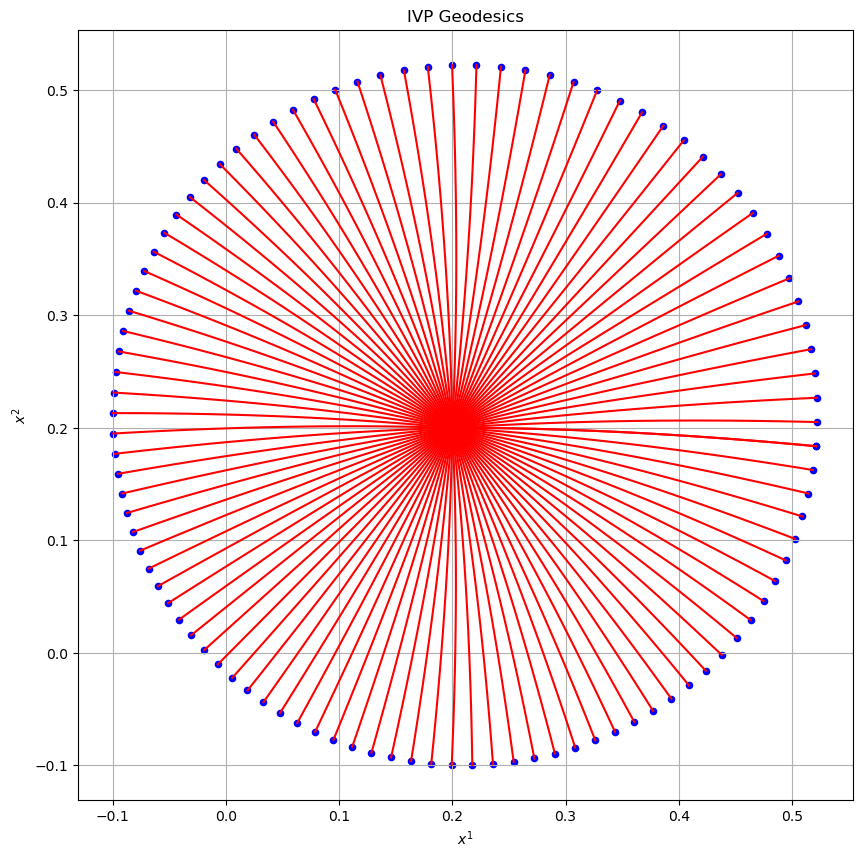

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig(figure_path+'ivp2d.pdf', format="pdf", bbox_inches="tight")

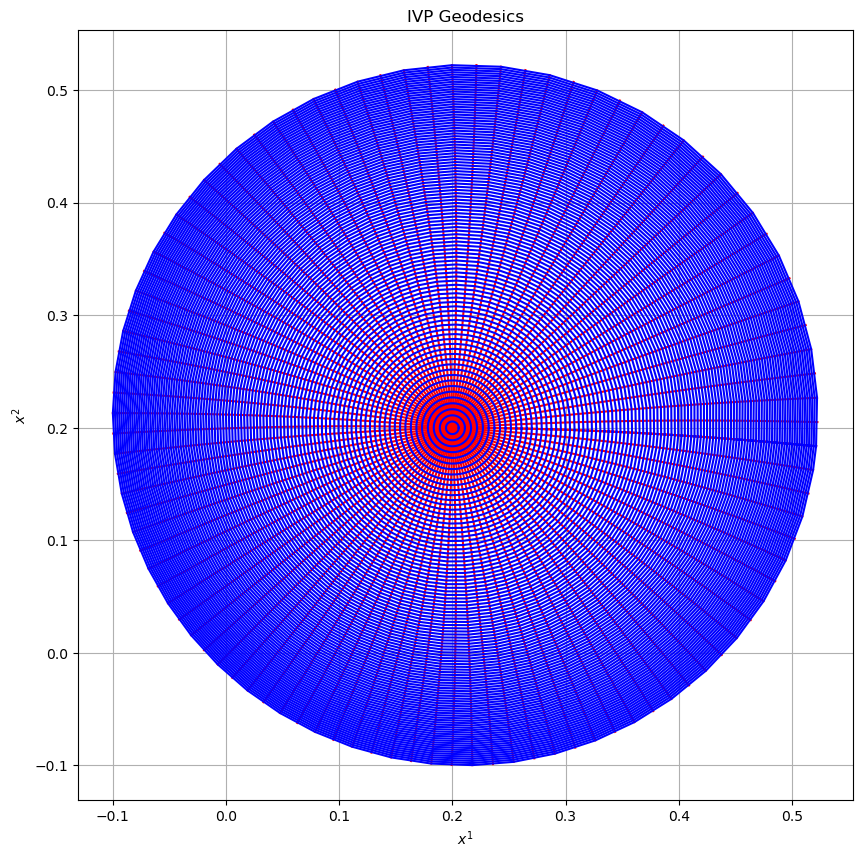

In [31]:
gamma_circle = jnp.concatenate((gamma, gamma[0].reshape(1,gamma.shape[1], gamma.shape[2])))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.plot(gamma_circle[:,:,0][::2], gamma_circle[:,:,1][::2], color='blue')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.grid()
fig.savefig(figure_path+'ivp2d_circle.pdf', format="pdf", bbox_inches="tight")

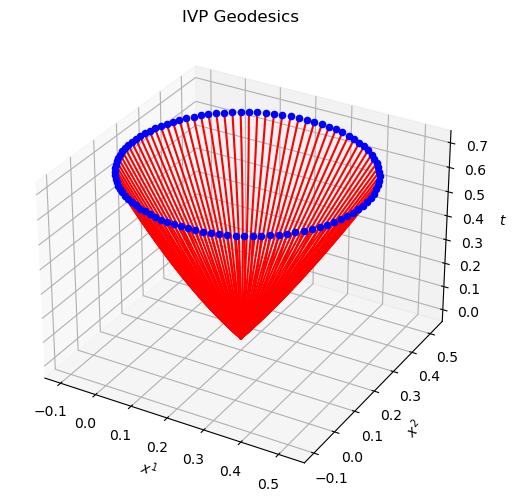

In [32]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig(figure_path+'ivp3d.pdf', format="pdf", bbox_inches="tight")

### Computing the Time Function

In [33]:
wavefront_xgrid = gamma.reshape(-1,2)
wavefront_x1grid = wavefront_xgrid[:,0]
wavefront_x2grid = wavefront_xgrid[:,1]
wavefront_tgrid = t.reshape(-1)

In [34]:
#Source: https://github.com/google/jax/discussions/10689
from jax import jit

#@jit
def bispline_interp(xnew,ynew,xp,yp,zp):
    """
    (xnew,ynew): two 1D vector  of same size where to perform predictions  f(xnew[i],ynew[i])
    (xp,yp): original grid points 1D vector
    zp: original values of functions  zp[i,j] = value at xp[i], yp[j]
    """
    
    
    M = 1./16 * jnp.array([[0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, -8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, 16, -40, 32, -8, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, -8, 24, -24, 8, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, -8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0], 
                           [4, 0, -4, 0, 0, 0, 0, 0, -4, 0, 4, 0, 0, 0, 0, 0], 
                           [-8, 20, -16, 4, 0, 0, 0, 0, 8, -20, 16, -4, 0, 0, 0, 0],
                           [4, -12, 12, -4, 0, 0, 0, 0, -4, 12, -12, 4, 0, 0, 0, 0],
                           [0, 16, 0, 0, 0, -40, 0, 0, 0, 32, 0, 0, 0, -8, 0, 0], 
                           [-8, 0, 8, 0, 20, 0, -20, 0, -16, 0, 16, 0, 4, 0, -4, 0], 
                           [16, -40, 32, -8, -40, 100, -80, 20, 32, -80, 64, -16, -8, 20, -16, 4], 
                           [-8, 24, -24, 8, 20, -60, 60, -20, -16, 48, -48, 16, 4, -12, 12, -4], 
                           [0, -8, 0, 0, 0, 24, 0, 0, 0, -24, 0, 0, 0, 8, 0, 0], 
                           [4, 0, -4, 0, -12, 0, 12, 0, 12, 0, -12, 0, -4, 0, 4, 0], 
                           [-8, 20, -16, 4, 24, -60, 48, -12, -24, 60, -48, 12, 8, -20, 16, -4], 
                           [4, -12, 12, -4, -12, 36, -36, 12, 12, -36, 36, -12, -4, 12, -12, 4]]
                         )
    
    M1 = jnp.array([[1.,0.,0.,0.],
                    [-1.,1.,0.,0.],
                    [-1.,0.,1.,0.],
                    [1.,-1.,-1.,1.]])

    def built_Ivec(zp,idx):
        return jnp.array([zp[idx+i+j] for j in range(-1,3) for i in range(-1,3)])


    def built_Ivec1(zp,idx):
        return jnp.array([zp[idx+i+j] for j in range(0,2) for i in range(0,2)])
    
    def compute_basis(x,order=3):
        """
        x in [0,1]
        """ 
        return jnp.array([x**i for i in jnp.arange(0, order+1)])
    
    def tval(xnew,idx,xp):
        return (xnew-xp[idx-1])/(xp[idx]-xp[idx-1])
    
    def bilinear_interp(idx):
        Iv = built_Ivec1(zp,idx-1-1)
        av = M1 @ Iv
        amtx = av.reshape(2,2,-1)
        tx = tval(xnew,idx,xp)
        ty = tval(ynew,idx,yp)
        basis_x = compute_basis(tx,order=1)
        basis_y = compute_basis(ty,order=1)
        res = jnp.einsum("i...,ij...,j...",basis_y,amtx,basis_x)
        return res

    def bispline_interp(idx):
        Iv = built_Ivec(zp,idx-1-1)
        av = M @ Iv
        amtx = av.reshape(4,4,-1)
        tx = tval(xnew,idx,xp)
        ty = tval(ynew,idx,yp)
        basis_x = compute_basis(tx)
        basis_y = compute_basis(ty)
        res = jnp.einsum("i...,ij...,j...",basis_y,amtx,basis_x)
        return res
    
    idx_sort = xp.argsort()
    xp = xp[idx_sort]
    yp = yp[idx_sort]
    zp = zp[idx_sort]
    
    val_x = jnp.abs(xp-xnew)
    val_x = jnp.abs(jnp.min(val_x)-val_x)
    idx_x = jnp.where(val_x<1e-8, jnp.arange(val_x.shape[0]), val_x.shape[0])
    
    val_y = jnp.concatenate((jnp.abs(yp-ynew), jnp.ones(1)*jnp.max(yp)))[idx_x]
    idx = jnp.argmin(val_y)
    
    cond = jnp.logical_and(idx>=2, idx<=len(xp)-2)

    return jnp.where(cond,
             bispline_interp(idx),
             bilinear_interp(idx))

In [35]:
def time_fun(x):
    
    return bispline_interp(x[0], x[1], wavefront_x1grid, wavefront_x2grid, 
                   wavefront_tgrid)


### Plotting the Time Function

In [36]:
N_grid = 100
x1 = jnp.linspace(jnp.min(wavefront_x1grid), jnp.max(wavefront_x1grid), N_grid)
x2 = jnp.linspace(jnp.min(wavefront_x2grid), jnp.max(wavefront_x2grid), N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
time_fun_grid = (vmap(lambda x: vmap(lambda y: time_fun(y))(x))(X)).squeeze()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


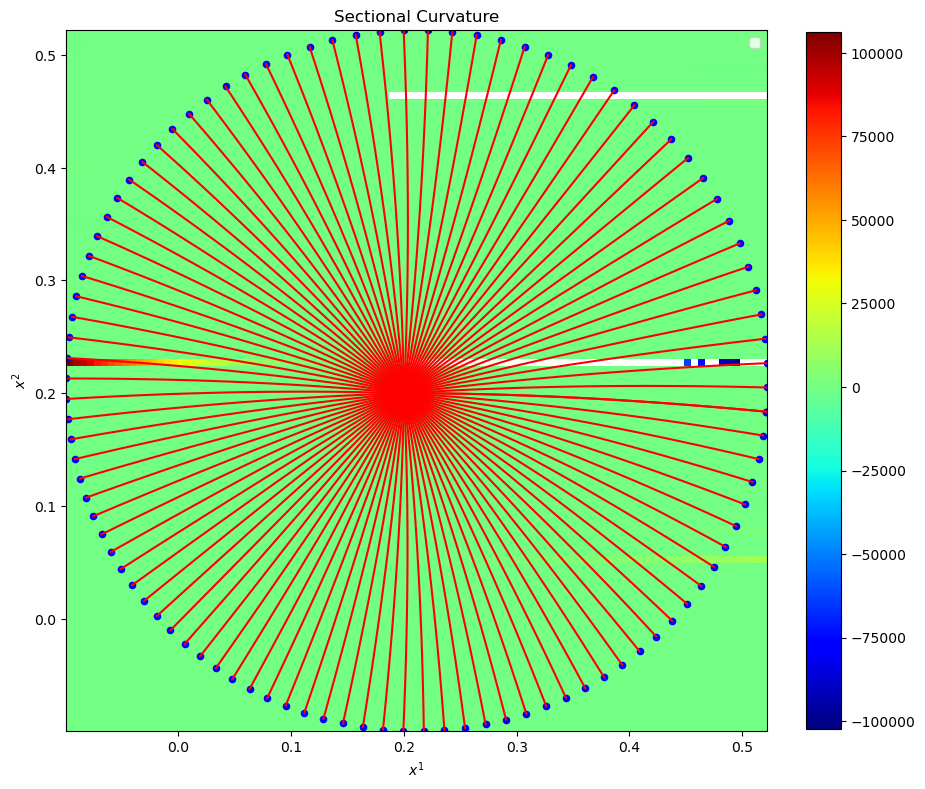

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)

ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)

heatmap = time_fun_grid
extent = [jnp.min(gamma[:,:,0]), jnp.max(gamma[:,:,0]), jnp.min(gamma[:,:,1]), jnp.max(gamma[:,:,1])]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([jnp.min(gamma[:,:,0]), jnp.max(gamma[:,:,0])])
ax.set_ylim([jnp.min(gamma[:,:,1]), jnp.max(gamma[:,:,1])])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig(figure_path+"time_fun.pdf", format="pdf", bbox_inches="tight")

### Defining The Frozen Metric

In [38]:
Gtilde = lambda x: jnp.squeeze(G(time_fun(x), x, jnp.zeros(3)))
RM = RiemannianManifold(G=Gtilde, dim=2, GeodesicMethod="ODE", ODEMethod = "rk4", maxiter=10000, tol=1e-6)

### Estimating the Sectional Curvature of the Frozen Metric

In [39]:
N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(jnp.min(wavefront_x1grid), jnp.max(wavefront_x1grid), N_grid)
x2 = jnp.linspace(jnp.min(wavefront_x2grid), jnp.max(wavefront_x2grid), N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: RM.SectionalCurvature(y, e1, e2))(x))(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


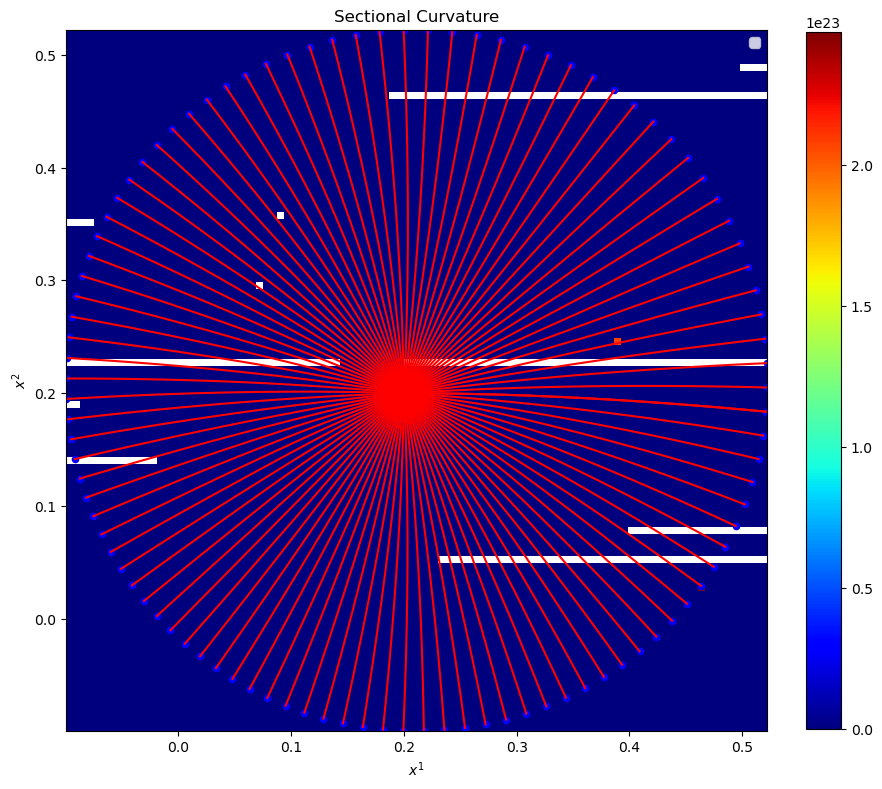

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)

ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)

heatmap = sec
extent = [jnp.min(gamma[:,:,0]), jnp.max(gamma[:,:,0]), jnp.min(gamma[:,:,1]), jnp.max(gamma[:,:,1])]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([jnp.min(gamma[:,:,0]), jnp.max(gamma[:,:,0])])
ax.set_ylim([jnp.min(gamma[:,:,1]), jnp.max(gamma[:,:,1])])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig(figure_path+"frozen_curvature.pdf", format="pdf", bbox_inches="tight")